In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import cartopy
import cartopy.crs as ccrs
import pandas as pd
from datetime import date, timedelta

In [40]:
case = "fanv3_1th"
path = "/glade/scratch/jinmuluo/archive/" + case + "/lnd/hist/" 
start_date = date(2012, 12, 1)
end_date = date(2013, 1, 1)
delta = end_date - start_date
fields = ["N2O_DENITRIFY_TOTAL", "N2O_NITRIFY_TOTAL", "NOx_DENITRIFY_TOTAL", "NOx_NITRIFY_TOTAL", "area"]
fanCLM = []
for i in range(delta.days + 1):
    day = start_date + timedelta(days=i)
    day = day.strftime('%Y-%m-%d')
    fanCLM.append(path + case + ".clm2.h6." + day +"-00000.nc")
print(len(fanCLM), fanCLM[0])

32 /glade/scratch/jinmuluo/archive/fanv3_1th/lnd/hist/fanv3_1th.clm2.h6.2012-12-01-00000.nc


In [43]:
def preprocess (ds, fields = fields):
    return(ds[fields])

def fix_time(ds):  
    yr0 = ds['time'][0].values
    yr1 = ds['time'][-1].values
    # ds['time'] =xr.cftime_range(str(yr0),periods=ndays,freq='D')
    ds['time'] = pd.date_range(str(yr0),str(yr1),freq='30min') 
    return ds

dsCLM = fix_time(xr.open_mfdataset(fanCLM, decode_times=True, preprocess=preprocess))
dsCLM

<xarray.Dataset>
Dimensions:              (lat: 96, lon: 144, time: 1489)
Coordinates:
  * time                 (time) datetime64[ns] 2012-12-01 ... 2013-01-01
  * lon                  (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                  (lat) float32 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
Data variables:
    N2O_DENITRIFY_TOTAL  (time, lat, lon) float32 dask.array<chunksize=(48, 96, 144), meta=np.ndarray>
    N2O_NITRIFY_TOTAL    (time, lat, lon) float32 dask.array<chunksize=(48, 96, 144), meta=np.ndarray>
    NOx_DENITRIFY_TOTAL  (time, lat, lon) float32 dask.array<chunksize=(48, 96, 144), meta=np.ndarray>
    NOx_NITRIFY_TOTAL    (time, lat, lon) float32 dask.array<chunksize=(48, 96, 144), meta=np.ndarray>
    area                 (time, lat, lon) float32 dask.array<chunksize=(48, 96, 144), meta=np.ndarray>
Attributes:
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 01/16/23 17:16:12
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    username:                             jinmuluo
    version:                              unknown
    revision_id:                          $Id: histFileMod.F90 42903 2012-12-...
    case_title:                           fanv3_1th
    case_id:                              fanv3_1th
    Surface_dataset:                      surfdata_1.9x2.5_hist_78pfts_CMIP6_...
    Initial_conditions_dataset:           finidat_interp_dest.nc
    PFT_physiological_constants_dataset:  clm50_params.c211112.nc
    ltype_vegetated_or_bare_soil:         1
    ltype_crop:                           2
    ltype_UNUSED:                         3
    ltype_landice:                        4
    ltype_deep_lake:                      5
    ltype_wetland:                        6
    ltype_urban_tbd:                      7
    ltype_urban_hd:                       8
    ltype_urban_md:                       9
    ctype_vegetated_or_bare_soil:         1
    ctype_crop:                           2
    ctype_crop_noncompete:                2*100+m, m=cft_lb,cft_ub
    ctype_landice:                        4*100+m, m=1,glcnec
    ctype_deep_lake:                      5
    ctype_wetland:                        6
    ctype_urban_roof:                     71
    ctype_urban_sunwall:                  72
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    cft_temperate_corn:                   3
    cft_irrigated_temperate_corn:         4
    cft_spring_wheat:                     5
    cft_irrigated_spring_wheat:           6
    cft_winter_wheat:                     7
    cft_irrigated_winter_wheat:           8
    cft_temperate_soybean:                9
    cft_irrigated_temperate_soybean:      10
    cft_barley:                           11
    cft_irrigated_barley:                 12
    cft_winter_barley:                    13
    cft_irrigated_winter_barley:          14
    cft_rye:                              15
    cft_irrigated_rye:                    16
    cft_winter_rye:                       17
    cft_irrigated_winter_rye:             18
    cft_cassava:                          19
    cft_irrigated_cassava:                20
    cft_citrus:                           21
    cft_irrigated_citrus:                 22
    cft_cocoa:                            23
    cft_irrigated_cocoa:                  24
    cft_coffee:                           25
    cft_irrigated_coffee:                 26
    cft_cotton:                           27
    cft_irrigated_cotton:                 28
    cft_datepalm:                         29
    cft_irrigated_d

In [44]:
def sp_plot(ds, field, coords, show=False):
    sp = ds.sel(lat=coords[0], lon=coords[1], method='nearest')
    sp[field] = sp[field] * 1000 * 3600 * 24
    sp[field].attrs['units'] = 'kgN/km2/day'
    if show:
        sp[field].plot(x='time')
        plt.show()
    return sp

In [55]:
def tot_plot(ds, field, show=False):
    # calculate global total emission (kgN/day)
    ds[field] = ds[field] * ds['area']* 3600 * 24 
    ds[field].attrs['units'] = 'kgN/day'
    total = ds[field].sum(dim=['lat', 'lon'])
    if show:
        total.plot(x='time')
        plt.show()
    return total

In [54]:
def regional_plot(ds, field, coords, show=False):
    x = slice(coords['lower_lat'], coords['upper_lat'])
    y = slice(coords['west_lon'], coords['east_lon'])
    rp = ds[field].sel(lat=x, lon=y).sum(dim=['lat', 'lon'])
    if show:
        rp.plot(x='time')
        plt.show()
    return rp

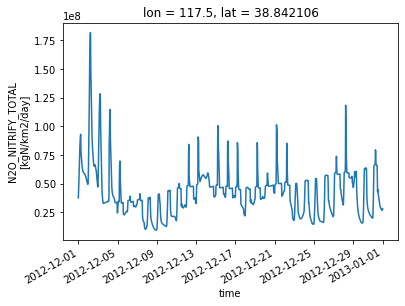

array([37722750., 41279988., 46692396., ..., 26831120., 27507456.,
       28357612.], dtype=float32)

In [53]:
coordinates = [39.24, 116.25]
sp = sp_plot(ds=dsCLM, field=fields[1], coords=coordinates, show=True)
sp[fields[1]].values

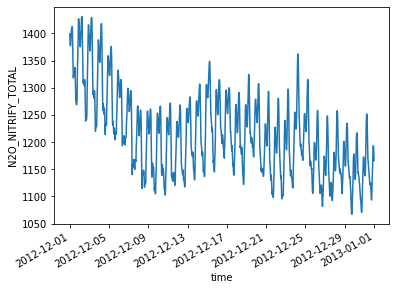

0

In [52]:
tot_plot(ds=dsCLM, field=fields[1], show=True)

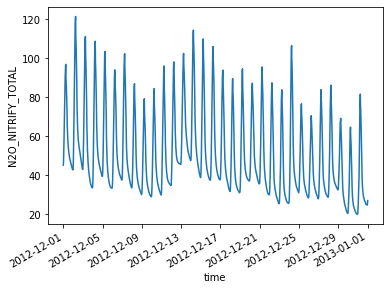

<xarray.DataArray 'N2O_NITRIFY_TOTAL' (time: 1489)>
dask.array<sum-aggregate, shape=(1489,), dtype=float32, chunksize=(48,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2012-12-01 2012-12-01T00:30:00 ... 2013-01-01

In [57]:
coordinates = {'upper_lat':45.50, 'lower_lat':25.35, 'west_lon': 100.00, 'east_lon':130.00}
regional_plot(ds=dsCLM, field=fields[1], coords=coordinates, show=True)